In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import wandb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE, QuantileLoss, PoissonLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 128 if AVAIL_GPUS else 32

In [2]:
pl.seed_everything(125)

Global seed set to 125


125

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 1. Data Description

In [4]:
def gen_data(n, range_x=[-2, 2], scale_noise=0.2, sc=None):
    x = torch.linspace(range_x[0], range_x[1], n)
    y_true = x + torch.sin(x * 2 * torch.pi)
    y_noise = y_true + torch.randn((n,)) * scale_noise
    if sc is None:
        return x, y_noise, y_true
    else:
        y_true = sc.transform(y_true.reshape(-1, 1))
        y_noise = sc.transform(y_noise.reshape(-1, 1))
        y_true = torch.tensor(y_true, dtype=torch.float)
        y_noise = torch.tensor(y_noise, dtype=torch.float)
        return x, y_noise, y_true

arr_x, arr_y_noise, arr_y = gen_data(1500)

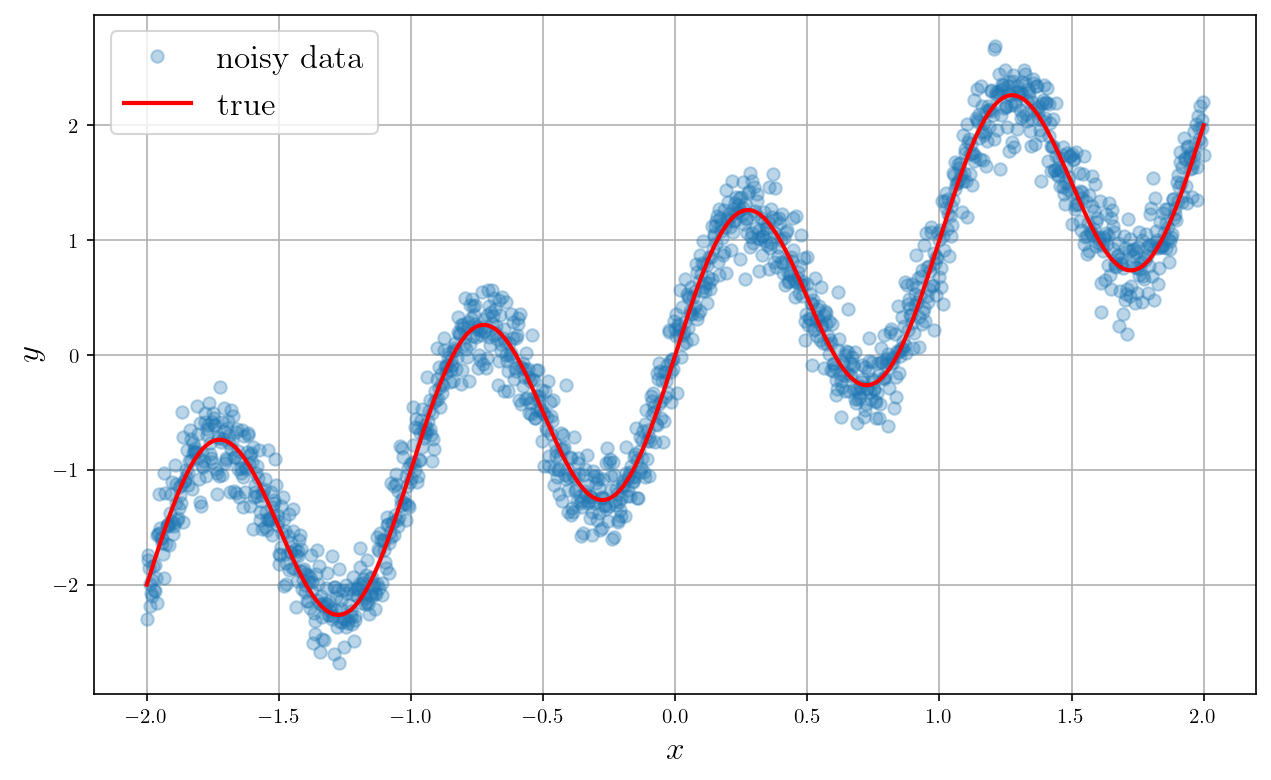

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(arr_x, arr_y_noise, 'o', label='noisy data', alpha=0.3)
plt.plot(arr_x, arr_y, 'r-', linewidth=2,label='true')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

In [6]:
sc = MinMaxScaler()
sc.fit(arr_y.reshape(-1,1))
y_noise_norm = torch.tensor(sc.transform(arr_y_noise.reshape(-1,1)))
y_norm = torch.tensor(sc.transform(arr_y.reshape(-1,1)))
y_normalized = torch.column_stack([y_noise_norm, y_norm])

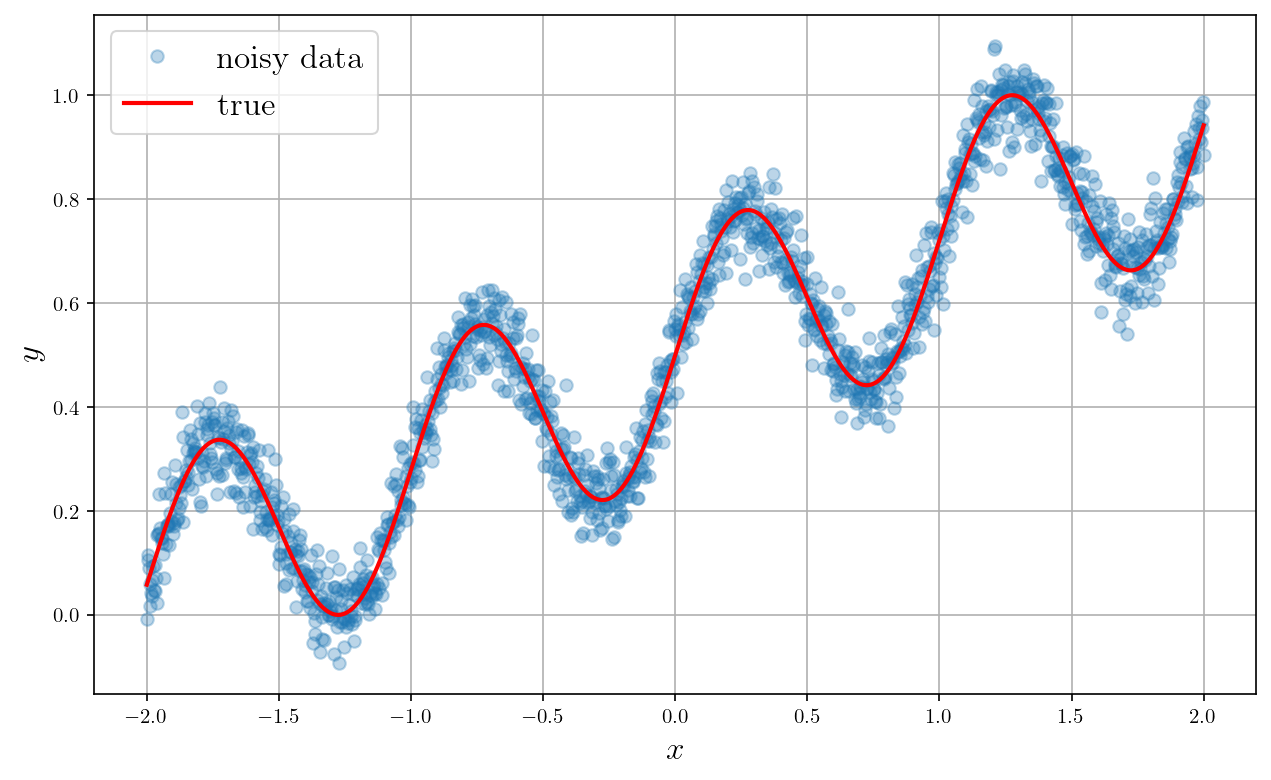

In [7]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(arr_x, y_normalized[:,0], 'o', label='noisy data', alpha=0.3)
plt.plot(arr_x, y_normalized[:,1], 'r-', linewidth=2,label='true')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 2. Make Dataset

In [8]:
class NoisyData(Dataset):
    def __init__(self, x, y, y_true):
        self.x = x.reshape((-1,1))
        self.y = y.reshape((-1,1))
        self.y_true = y_true.reshape((-1,1))
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.y_true[idx]

In [9]:
def gen_noisy_data(n, range_x=[-2,4], sc=None):
    return NoisyData(*gen_data(n, range_x=range_x, sc=sc))

## 3. MLP 1

### 3.1. Define Model

In [10]:
class NoisyNet(pl.LightningModule):
    def __init__(self, N=10000, hparams=None):
        super().__init__()
        
        self.N = N
        
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1)
        )
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
        self.save_hyperparameters(hparams)
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('train_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        self.ds = NoisyData(*gen_data(self.N, range_x=[-2, 2], sc=sc))
        self.ds2 = NoisyData(*gen_data(self.N // 5, range_x=[-2, 2], sc=sc))
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds2, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [11]:
# hparams = {
#     "learning_rate": 1e-3,
#     "batch_size": BATCH_SIZE,
#     "epochs": 10000
# }

# model = NoisyNet(
#     hparams=hparams
# )

# wandb_logger = WandbLogger(
#     project='MLP2Autoregressive'
# )

# trainer = Trainer(
#     logger=wandb_logger,
#     max_epochs=hparams['epochs'],
#     gpus=AVAIL_GPUS,
#     enable_progress_bar=False,
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=50, mode='min')
#     ]
    
# )

### 3.2. Train

In [12]:
# trainer.fit(model)

In [13]:
# wandb.finish()

In [14]:
# best_path = trainer.checkpoint_callback.best_model_path
# print(best_path)
best_path = "/home/xteca/Documents/Project/Machine_Learning/MLTest/MLP2Autoregressive/2nakj4gy/checkpoints/epoch=103-step=5720.ckpt"
best_model = NoisyNet.load_from_checkpoint(best_path)
best_model.eval()

NoisyNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

### 3.3. Test

In [15]:
test_data = gen_noisy_data(1000, range_x=[-2,2], sc=sc)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

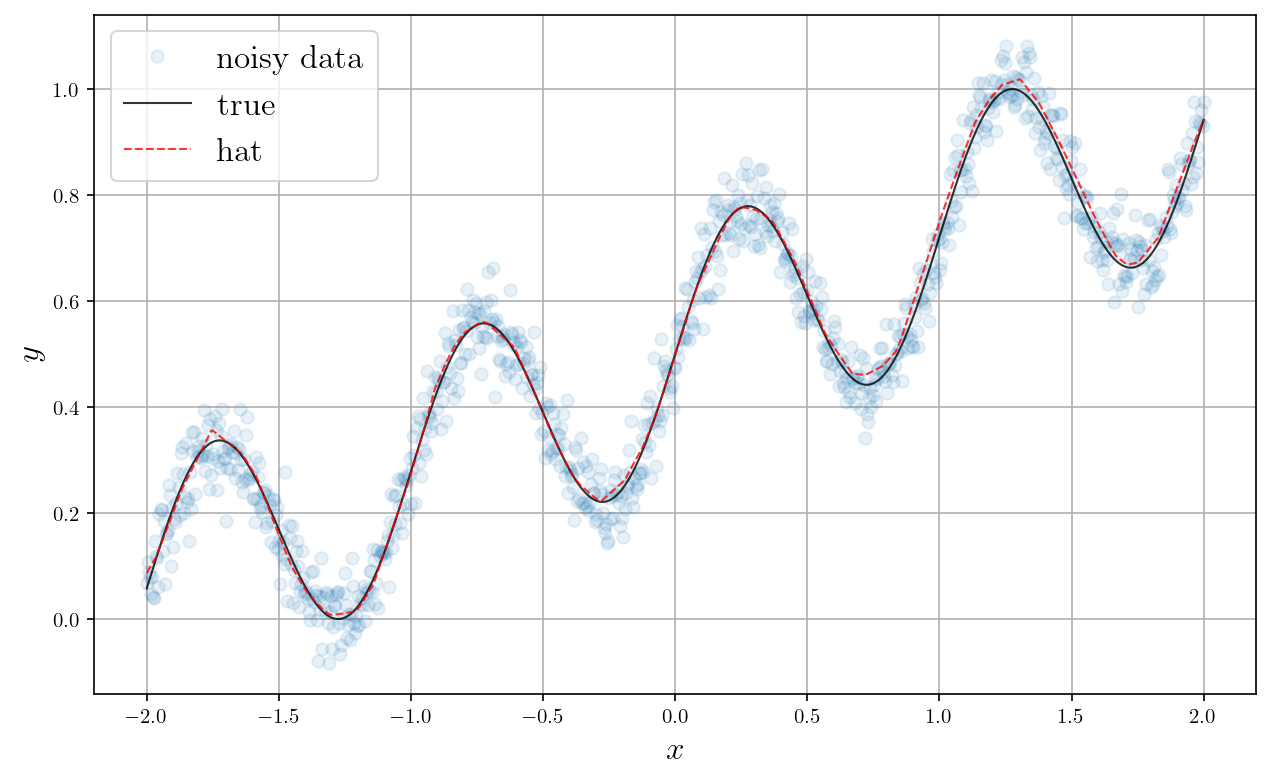

In [16]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

In [17]:
inv = sc.inverse_transform

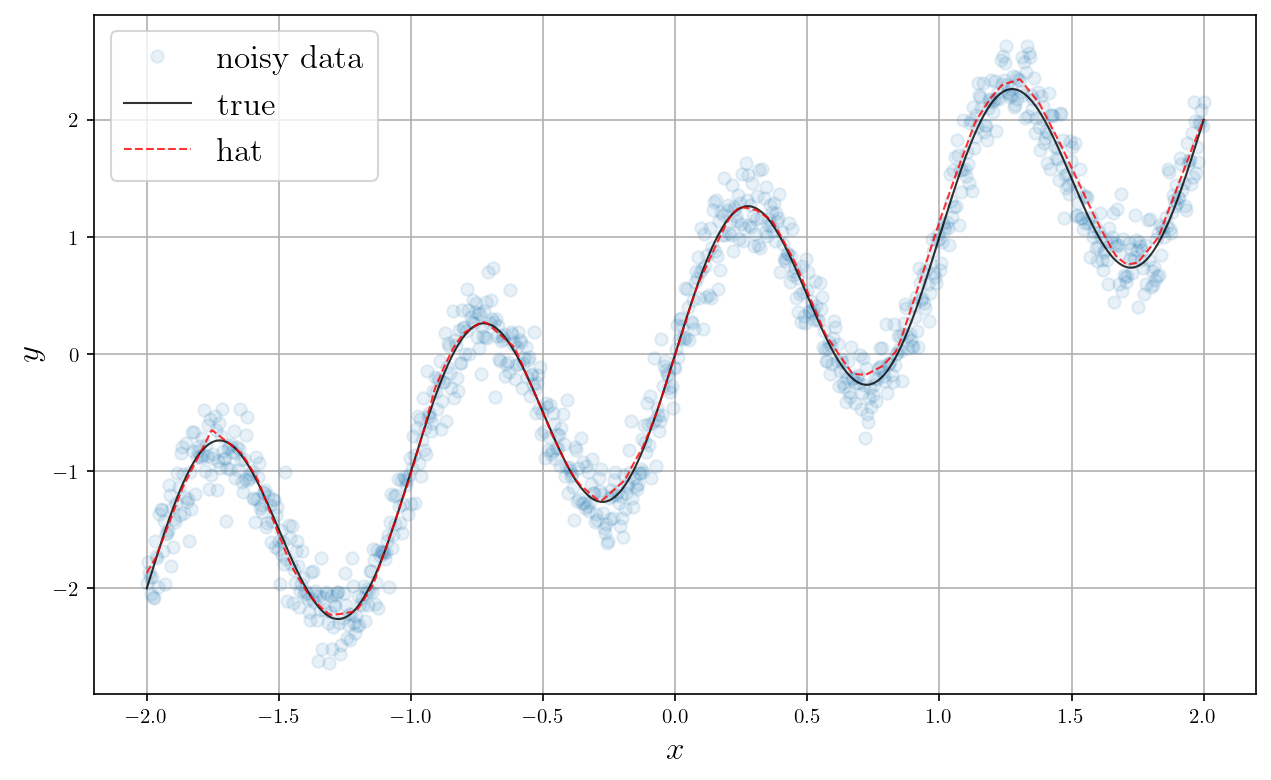

In [18]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, inv(y), 'o', label='noisy data', alpha=0.1)
plt.plot(x, inv(y_true), 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, inv(y_hat), 'r--', linewidth=1, label='hat', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 4. TimeSeries Data

In [19]:
ts_data = pd.DataFrame(
    dict(
        y=y_hat.flatten(),
        group=np.repeat(0, len(y)),
        time_idx=np.arange(len(y_hat))
    )
)
ts_data

,y,group,time_idx
0,0.087055,0,0
1,0.090470,0,1
2,0.093888,0,2
3,0.097306,0,3
4,0.100724,0,4
...,...,...,...
995,0.923153,0,995
996,0.928190,0,996
997,0.933196,0,997
998,0.938066,0,998


In [20]:
ts_data = ts_data.astype(dict(group=str))

In [21]:
max_encoder_length = 100
max_prediction_length = 20

cutoff = ts_data["time_idx"].max() - max_prediction_length

ds_train = TimeSeriesDataSet(
    ts_data[lambda x: x.time_idx <= cutoff],
    target="y",
    time_idx="time_idx",
#     categorical_encoders={"group": NaNLabelEncoder().fit(ts_data.group)},
    group_ids=["group"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["y"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length
)

ds_val = TimeSeriesDataSet.from_dataset(ds_train, ts_data, min_prediction_idx=cutoff + 1)

In [22]:
ts_dl = ds_val.to_dataloader(batch_size=2)

x, y = next(iter(ts_dl))

In [23]:
dl_train = ds_train.to_dataloader(
    train=True, batch_size=100, num_workers=0, batch_sampler="synchronized"
)

dl_val = ds_val.to_dataloader(
    train=False, batch_size=100, num_workers=0, batch_sampler="synchronized"
)

In [24]:
# calc basline abs error
actuals = torch.cat([y[0] for x, y in iter(dl_val)])
baseline_pred = Baseline().predict(dl_val)
SMAPE()(baseline_pred, actuals)

tensor(0.0619)

## 5. Temporal Fusion Transformer

In [25]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_loss",
        "goal": "minimize"
    },
    "parameters": {
        "init_lr": {
            "distribution": "log_uniform",
            "min": -9.210340371976182,
            "max": -2.3025850929940455
        },
    }
}

In [26]:
sweep_id = wandb.sweep(sweep_config, project="MLP2Autoregressive")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. init_lr uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: uscq307u
Sweep URL: https://wandb.ai/axect/MLP2Autoregressive/sweeps/uscq307u


In [27]:
def sweep_iteration():
    pl.seed_everything(125)
    wandb.init()
    wandb_logger = WandbLogger()
    
    model2 = TemporalFusionTransformer.from_dataset(
        ds_train,
        learning_rate=wandb.config.init_lr,
        hidden_size=20,
        attention_head_size=4,
        dropout=0.1,
        hidden_continuous_size=10,
        output_size=7, # 7-quantiles
        loss=QuantileLoss(),
        reduce_on_plateau_patience=4,
    )
    
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        verbose=False,
        mode="min"
    )

    trainer = Trainer(
        logger=wandb_logger,
        max_epochs=30,
        gpus=AVAIL_GPUS,
        weights_summary="top",
        gradient_clip_val=0.1,
        callbacks=[
            early_stop_callback,
            LearningRateMonitor(logging_interval="epoch")
        ],
        enable_progress_bar=False,
    )
    
    trainer.fit(model2, train_dataloaders=dl_train, val_dataloaders=dl_val)

In [28]:
wandb.agent(sweep_id, function=sweep_iteration, count=10)

wandb: Agent Starting Run: 1vqz5l5k with config:
wandb: 	init_lr: 0.0009158042635401946
Global seed set to 125
wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Ranger,████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
train_loss_epoch,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▇▆▄▄▂▂▂▅▃▂▂▂▃▂▁▂▁▁▁▁▁▁▃▂▁▁▁▁▁▂▁▃▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▂▂▁▂▁▂▂▁
val_MAPE,█▆▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▂▁▂▁▂▂▁
val_RMSE,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▂▂▂▂▁▂▂▁
val_SMAPE,█▅▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▂▁▂▁▁▂▁
val_loss,█▄▃▂▂▂▁▁▂▂▁▂▂▂▁▂▁▁▁▁▂▂▁▂▁▂▁▁▂▁
epoch,30


wandb: Agent Starting Run: 831jb135 with config:
wandb: 	init_lr: 0.06776080116181217
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
lr-Ranger,████████████▁▁▁▁▁
train_loss_epoch,▄▁▁▁▄█▆█▇▇▇█▇▇▇▇▇
train_loss_step,▄▂▃▃▂▂▂▄▄▄▃▃▅▁▃▃▃▄▅▅▃▃▃▂▄▄▆▄▆▅▂▄▄▅▃▅▄▂▆█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,▃▃▂▁▄▂▁█▅▅▆▅▅▅▅▄▅
val_MAPE,▃▃▂▁▄▂▁█▅▅▆▅▅▅▅▄▅
val_RMSE,▂▃▂▁▃▂▁█▅▅▆▅▅▅▅▄▅
val_SMAPE,▂▃▂▁▃▂▁█▅▅▆▅▅▄▄▄▅
val_loss,▂▃▂▁▃▁▁█▅▅▅▄▅▄▅▅▅
epoch,17


wandb: Agent Starting Run: 2u2f44di with config:
wandb: 	init_lr: 0.00084581792475739
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Ranger,█████████████████████████▁▁▁▁▁
train_loss_epoch,█▆▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▅▃▅▃▃▃▂▂▂█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,▆█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_MAPE,▆█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_RMSE,▆█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_SMAPE,▆█▃▃▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▃▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: inavi9hp with config:
wandb: 	init_lr: 0.00034952637115607865
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
lr-Ranger,████████████▁▁▁▁▁
train_loss_epoch,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁
train_loss_step,▅▅▂▄▅█▆▄▅▆▅▅▅▂▃▂▄▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▂▁▂▁▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,▇▇█▄▃▂▁▂▁▂▂▂▂▂▂▂▂
val_MAPE,▇▇█▄▃▂▁▂▁▂▂▂▂▂▂▂▂
val_RMSE,▇▇█▄▃▂▁▂▂▂▂▂▂▂▂▂▂
val_SMAPE,▇▇█▄▃▂▁▂▁▂▂▂▂▂▂▂▂
val_loss,█▇█▄▃▂▁▂▂▃▂▃▂▂▂▂▃
epoch,17


wandb: Agent Starting Run: docka6ml with config:
wandb: 	init_lr: 0.01940584881263472
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Ranger,█████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
train_loss_epoch,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▃▂▂▄▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▃▂▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,█▃▂▁▂▂▂▂▂▂▁▂▂▁▂▃▂▁▂▂▁▃▁▂▂▂▁▂
val_MAPE,█▃▂▁▂▂▂▂▂▂▁▂▂▁▂▃▂▁▂▂▁▃▁▂▂▂▁▂
val_RMSE,█▄▃▁▂▂▃▂▂▂▁▂▂▁▂▃▂▁▂▂▁▃▁▂▂▂▂▂
val_SMAPE,█▃▂▁▂▂▂▂▂▂▁▂▂▁▂▃▂▁▂▂▁▃▁▂▂▁▁▂
val_loss,█▃▂▁▂▂▂▂▂▂▁▁▂▁▂▃▂▁▂▂▁▃▁▂▂▂▂▂
epoch,28


wandb: Agent Starting Run: pb42gypb with config:
wandb: 	init_lr: 0.00031866433392859487
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
lr-Ranger,███████▁▁▁▁▁
train_loss_epoch,█▅▅▄▄▄▂▂▁▁▁▁
train_loss_step,█▁▂▁▃▄▃▄▅▄▅▅▄▂▆▂▅▅▄▁▁▄▂▁▂▂▂▁▂▃▄▁▁▂▂▁▂▁▃▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_MAE,▁▁▂▂▃▆▇▇███▆
val_MAPE,▁▁▂▂▃▆▇▇███▆
val_RMSE,▁▁▂▂▃▆▇▇███▆
val_SMAPE,▁▁▂▂▃▆▇▇███▆
val_loss,▂▁▁▁▂▅▇████▇
epoch,12


wandb: Agent Starting Run: wbq8wd7s with config:
wandb: 	init_lr: 0.0016980954145099992
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
lr-Ranger,███████████████████▁▁▁▁▁
train_loss_epoch,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▅▃█▄▃▅▃▂▄▁▂▁▂▂▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_MAE,█▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_MAPE,█▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_RMSE,█▆▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_SMAPE,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24


wandb: Agent Starting Run: mykq8c16 with config:
wandb: 	init_lr: 0.00017081674153661983
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Ranger,█████████████████████▁▁▁▁▁
train_loss_epoch,█▆▅▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss_step,▃▂▂█▄▆▂▂▇▃▂▂▃▄▄▁▁▂▂▁▂▂▁▂▁▃▂▁▁▂▃▁▁▁▁▂▂▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,▇▇▇▇██▅▄▄▃▃▂▂▁▁▁▂▁▂▁▁▂▂▃▂▁
val_MAPE,▇▇▇▇██▅▄▄▃▃▂▂▁▁▁▂▁▂▁▁▂▂▃▂▁
val_RMSE,▇▇▇▇██▅▄▄▃▂▂▂▁▂▁▂▁▂▁▁▂▂▃▂▁
val_SMAPE,▇▇▇▇██▅▄▄▃▂▂▂▁▁▁▂▁▂▁▁▂▂▂▂▁
val_loss,█▇▇▇▇█▄▃▃▃▂▁▂▁▂▁▂▁▃▁▂▂▃▃▃▂
epoch,26


wandb: Agent Starting Run: 98kcdro0 with config:
wandb: 	init_lr: 0.0006801300616267555
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Ranger,██████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
train_loss_epoch,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▅▃█▄▄▄▂▂▂▂▃▂▂▁▁▂▂▁▁▂▁▂▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,▇█▄▂▁▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁
val_MAPE,▇█▄▂▁▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁
val_RMSE,▇█▄▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▂▁▁
val_SMAPE,▇█▄▂▁▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁
val_loss,██▃▂▁▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▂▁▁▂▁▂▁▁
epoch,30


wandb: Agent Starting Run: ez97iqdz with config:
wandb: 	init_lr: 0.00014498914166282342
Global seed set to 125


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 780   
7  | static_context_variable_selection  | GatedResidualNetw

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Ranger,██████████████████████▁▁▁▁▁▁▁▁
train_loss_epoch,█▆▅▅▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▄▁▄█▄▅▂▅▆▃▅▄▄▃▂▃▄▄▂▂▁▂▃▂▃▂▂▁▁▁▃▂▂▁▂▁▁▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_MAE,▇▇▇▇▇▇██▇▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_MAPE,▇▇▇▇▇▇██▇▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_RMSE,▇▇▇▇▇▇██▇▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_SMAPE,▇▇▇▇▇▇██▇▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▇▇▇▇▇▇█▇▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch,30


In [29]:
wandb.finish()


Aborted!
